In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.datasets import load_boston
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.models import Model

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Введение в искусственные нейронные сети
# Урок 3. TensorFlow

## Практическое задание

  1. Постройте нейронную сеть(берем простую линейную сеть, которую разбирали на уроке: меняем число слоев, число нейронов , типы активации, тип оптимизатора)  на датасет from sklearn.datasets import load_boston. 
  2. Измените функцию потерь и метрику для этой задачи. Постройте 10-15 вариантов и сведите результаты их работы в таблицу  Опишите, какого результата вы добились от нейросети? Что помогло вам улучшить ее точность?

  3. Поработайте с документацией TensorFlow 2. Найти 2-3 полезные команды TensorFlow, не разобранные на уроке (полезные для Вас).

  1-2. (*)  Попробуйте обучить нейронную сеть на TensorFlow 2 на датасете imdb_reviews .Опишите, какого результата вы добились от нейросети? Что помогло вам улучшить ее точность?
    
    
</ol>



## Набор данных для последнего ДЗ

- COVID 19 диагностика https://www.kaggle.com/andrewmvd/covid19-ct-scans

- Распознавание изображений цифр в представлении языка жестов https://www.kaggle.com/ardamavi/sign-language-digits-dataset

In [2]:
print(tf.__version__)
msg = tf.constant('TensorFlow 2.0 Hello World')
tf.print(msg)

2.4.1
TensorFlow 2.0 Hello World


In [3]:
x = tf.random.uniform([3, 3])

print("есть ли доступные GPU: ")
print(tf.config.experimental.list_physical_devices("GPU"))


print("тензор на GPU #0:  "),
print(x.device.endswith('GPU:0'))

есть ли доступные GPU: 
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
тензор на GPU #0:  
True


In [4]:
import time

def time_matmul(x):
  start = time.time()
  for loop in range(10):
    tf.matmul(x, x)

  result = time.time()-start

  print("10 циклов: {:0.2f}ms".format(1000*result))

# исполнение CPU
print(" CPU работает:")
with tf.device("CPU:0"):
  x = tf.random.uniform([1000, 1000])
  assert x.device.endswith("CPU:0")
  time_matmul(x)

# исполнение на GPU #0 , если доступен
if tf.config.experimental.list_physical_devices("GPU"):
  print(" какой GPU:")
  with tf.device("GPU:0"): # или GPU:1 , для 2х GPU, GPU:2 для 3х  и т.д.
    x = tf.random.uniform([1000, 1000])
    assert x.device.endswith("GPU:0")
    time_matmul(x)

 CPU работает:
10 циклов: 47.87ms
 какой GPU:
10 циклов: 426.86ms


### Загрузка данных

In [5]:
(train_features, train_labels), (test_features, test_labels) = keras.datasets.boston_housing.load_data()

# Нормализация.
train_mean = np.mean(train_features, axis=0)
train_std = np.std(train_features, axis=0)
train_features = (train_features - train_mean) / train_std
test_features = (test_features - train_mean) / train_std

print(train_features.shape) # (60000, 784)
print(test_features.shape)  # (10000, 784)

(404, 13)
(102, 13)


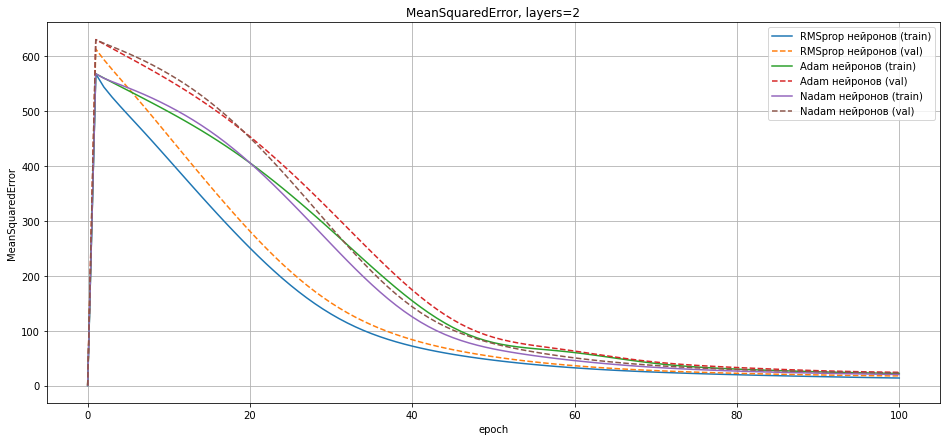

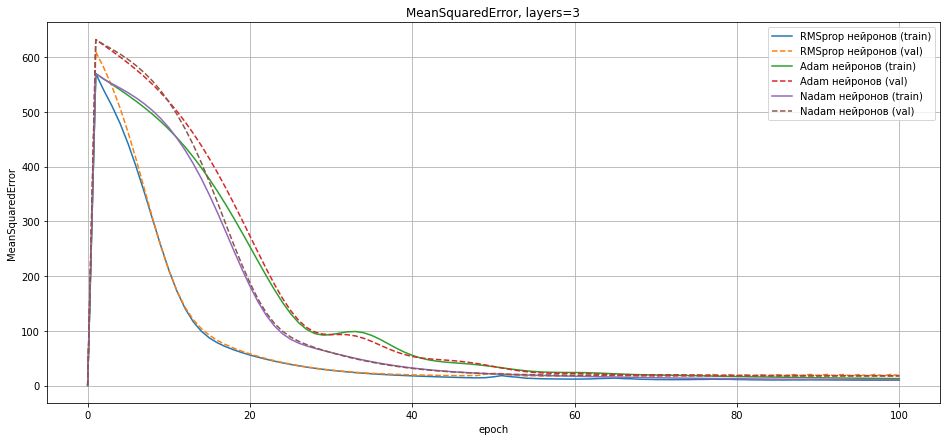

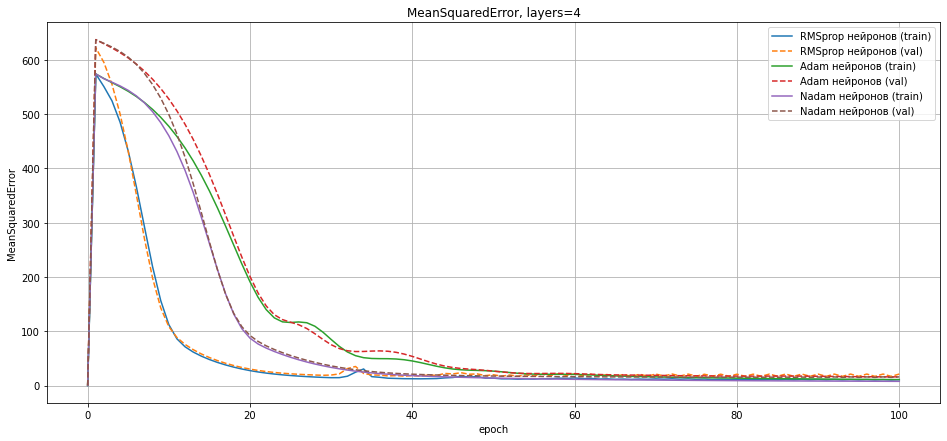

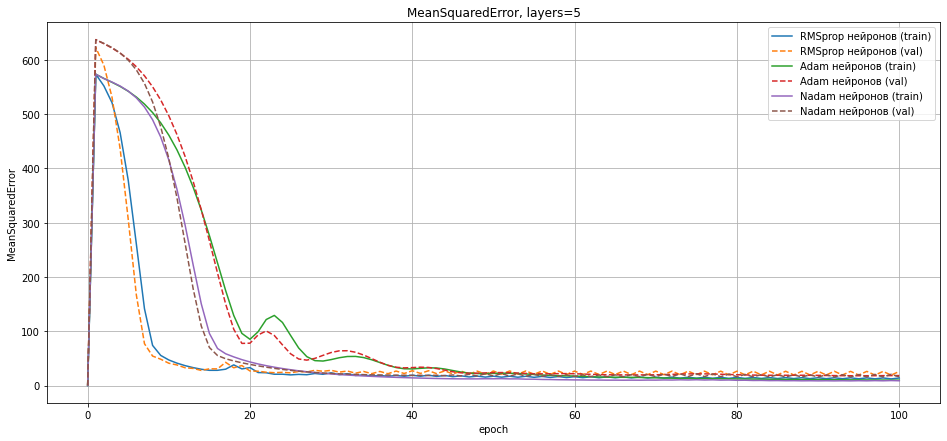

Wall time: 59.5 s


In [6]:
%%time 
layers = [2, 3, 4, 5]
for l in layers:
    
    model = keras.Sequential(name='my_model')
    model.add(keras.layers.Dense(128, activation='relu', input_shape=[len(train_features[0])]))
    for k in range(l-1):
              model.add(keras.layers.Dense(128, activation='relu')) 
    model.add(keras.layers.Dense(1, activation='linear')) 

    
    # сохраняем ее веса (это начальная точка) model.save_weights('model.h5')
    model.save_weights(f'{l}model.h5')

    plt.figure(figsize=(16,7))

    # число рабочих эпох
    epochs = 100
    
    # вектор для выводв результатов
    epoch = np.arange(epochs+1)

    #opt_list = [keras.optimizers.SGD( ),keras.optimizers.Adam( ),keras.optimizers.Nadam( )]
    for i_optim in ['RMSProp','adam','NAdam']:
        # создаем рабочую модель modeli куда будем загружать эти вес (она должна быть идентичной структуры)
        modeli = keras.Sequential(name='my_model')
        modeli.add(keras.layers.Dense(128, activation='relu', input_shape=[len(train_features[0])])) 
        for k in range(l-1):
          modeli.add(keras.layers.Dense(128, activation='relu')) 
        modeli.add(Dense(1, activation='linear')) 
        
      
        # загружаем веса modeli.load_weights('model.h5')
        modeli.load_weights(f'{l}model.h5')
        # компилируем modeli с одним из оптимизаторов
        modeli.compile(
            optimizer=i_optim,
            loss=tf.keras.losses.MeanSquaredError(),
              metrics=['MeanSquaredError']
        )

        # проводим обучение модели 
        hh = modeli.fit(
                      train_features,
                      train_labels,
                      epochs=epochs,
                      batch_size=1024, validation_split=0.2, verbose = 0
                      )
        # картинки
        plt.plot(epoch,[0]+hh.history['mean_squared_error'],'-',
                 label = modeli.optimizer.get_config()['name'] +' нейронов (train)')
        plt.plot(epoch,[0]+hh.history['val_mean_squared_error'],'--',
                 label = modeli.optimizer.get_config()['name'] +' нейронов (val)')
    plt.legend()
    plt.grid('On')

    plt.title('MeanSquaredError, layers='+str(l))
    plt.xlabel('epoch')
    plt.ylabel('MeanSquaredError')
    plt.show()

Наблюдение: RMSprop вроде выглядит неплохо

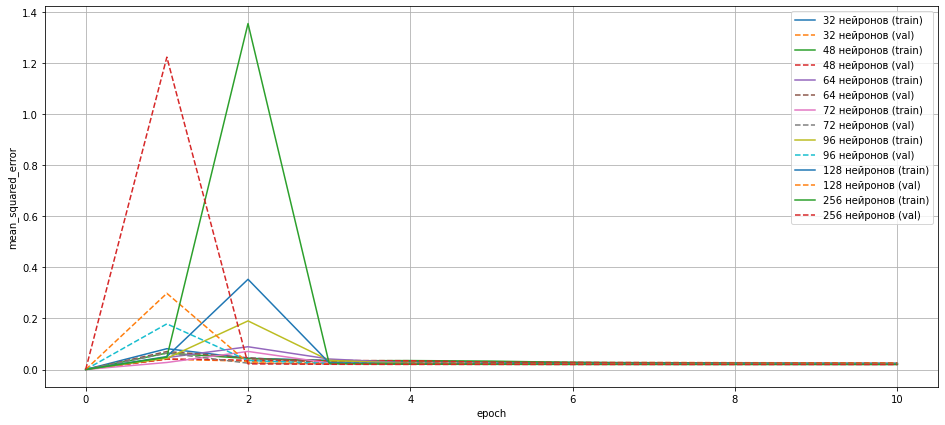

Wall time: 6.69 s


In [7]:
%%time 
neurons = [32, 48, 64, 72, 96, 128, 256]

plt.figure(figsize=(16,7))

for neuron in neurons:

    # создаем модель model
    modeli = keras.Sequential(name='my_model')
    modeli.add(keras.layers.Dense(neuron, activation='relu', input_shape=[len(train_features[0])])) 
    modeli.add(keras.layers.Dense(neuron, activation='relu')) 
    modeli.add(keras.layers.Dense(neuron, activation='relu')) 
    modeli.add(Dense(1, activation='linear')) 

    # число рабочих эпох
    epochs = 10
    # вектор для вывода результатов
    epoch = np.arange(epochs+1)

    modeli.compile(
        optimizer='RMSProp',
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=['MeanSquaredError']
    )

    # проводим обучение модели 
    hh = modeli.fit(
        train_features,
        to_categorical(train_labels),
        epochs=epochs,
        batch_size=1024, validation_split=0.2, verbose = 0
    )

    # картинки
    plt.plot(epoch,[0]+hh.history['mean_squared_error'],'-',label = str(neuron) +' нейронов (train)')
    plt.plot(epoch,[0]+hh.history['val_mean_squared_error'],'--',label = str(neuron) +' нейронов (val)')
    plt.legend()
    plt.grid('On')

plt.xlabel('epoch')
plt.ylabel('mean_squared_error')
plt.show()

Наблюдение: тут мало чего понятно, но выглядит так, будто 64 нейрона - это неплохой вариант

In [8]:
model = keras.Sequential()
model.add(keras.layers.Dense(64, activation='relu', input_shape=[len(train_features[0])])) 
model.add(keras.layers.Dense(64, activation='relu')) 
model.add(keras.layers.Dense(64, activation='relu')) 
model.add(Dense(1, activation='linear')) 

model.compile(optimizer='RMSProp',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['MeanSquaredError'])

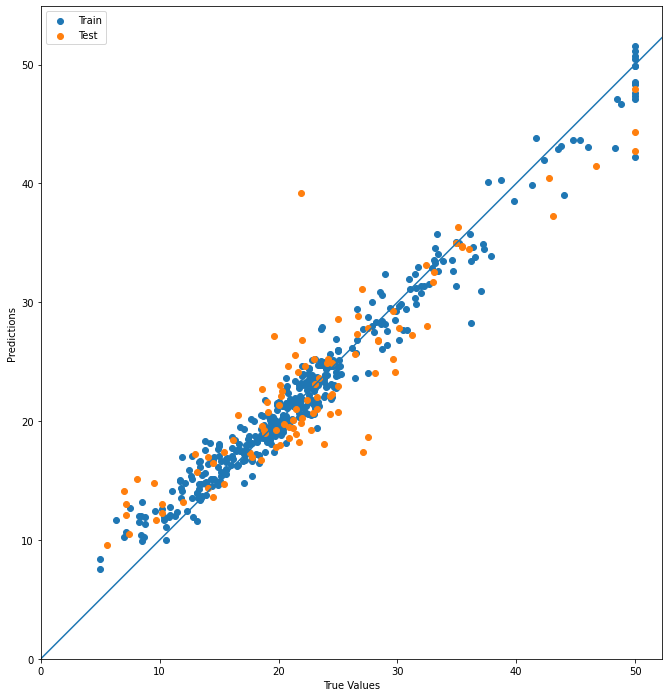

In [9]:
model.fit(train_features, train_labels, epochs=400, batch_size=100, verbose=0)

train_predictions = model.predict(train_features).flatten()
test_predictions = model.predict(test_features).flatten()
plt.figure(figsize=(12,12))
plt.scatter(train_labels, train_predictions, label='Train')
plt.scatter(test_labels, test_predictions, label='Test')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-70, 70], [-70, 70])
plt.legend()

In [10]:
rsq = r2_score(train_labels,train_predictions)
print('R-square, (Train): ',rsq)
rsq = r2_score(test_labels,test_predictions)
print('R-square, (Test): ',rsq)
mse = mean_squared_error(test_labels, test_predictions)
print('Mean Squared Error, Test: ',mse)

R-square, (Train):  0.9612510490951504
R-square, (Test):  0.8341411615562964
Mean Squared Error, Test:  13.806728023077659


Ну такое...